In [1]:
import numpy as np, pandas as pd, torch, os, glob
import pickle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold

os.environ["CUDA_VISIBLE_DEVICES"] = "6"

In [2]:
#pickle loading
# merge experiment
USD_data_train_pkl = glob.glob("./dataset/PeriHD_pickle_save/USD_sample2693_only-merge-sequence_contextsplit-pos_neg/train/*_fixed_re-marked_merge.pkl")
USD_data_valid_pkl = glob.glob("./dataset/PeriHD_pickle_save/USD_sample2693_only-merge-sequence_contextsplit-pos_neg/valid/*_fixed_re-marked_merge.pkl")

In [3]:
def pk2pf(pkl_list):
    data_train = []
    for pk in pkl_list:
        with open(pk, 'rb') as f:
            pk_dict = pickle.load(f)
        data_train.append(pk_dict)
    data_train = pd.DataFrame(data_train)
    
    return data_train
USD_data_train = pk2pf(USD_data_train_pkl)
USD_data_valid = pk2pf(USD_data_valid_pkl)

In [4]:
print(len(USD_data_train.label.values)-sum(USD_data_train.label.values), sum(USD_data_train.label.values))
print(len(USD_data_valid.label.values)-sum(USD_data_valid.label.values), sum(USD_data_valid.label.values))

10862 1173
1366 187


In [5]:
# print(len(USD_data_train.label.values)-sum(USD_data_train.label.values), sum(USD_data_train.label.values))
# print(len(USD_data_valid.label.values)-sum(USD_data_valid.label.values), sum(USD_data_valid.label.values))

In [6]:
# ### USD model embedding
USD_training_embeddings = np.array(USD_data_train.embed.tolist())
USD_validation_embeddings = np.array(USD_data_valid.embed.tolist())
print("Internal train", USD_training_embeddings.shape)
print("Internal test" ,USD_validation_embeddings.shape)

Internal train (12035, 512)
Internal test (1553, 512)


In [7]:
import keras
def create_model(input_shape = (512,)):
  model = keras.Sequential([
    keras.layers.Dense(256, activation='relu', input_shape = input_shape),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation='sigmoid')
  ])
  # model.compile(loss=FocalTverskyLoss, 
  #             optimizer='adam',
  #             metrics=['acc'])
  model.compile(loss='binary_crossentropy', 
              optimizer='adam',
              metrics=['acc'])
  return model

2023-04-04 16:32:15.102975: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-04 16:32:15.267446: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-04 16:32:15.770003: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-04-04 16:32:15.770072: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

2023-04-04 16:32:16.775936: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-04 16:32:18.338452: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21894 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:23:00.0, compute capability: 8.6


 68/377 [====>.........................] - ETA: 0s

2023-04-04 16:32:19.739926: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


49/49 [==============================] - 0s 914us/step


Text(0.5, 1.0, '[Internal][USD]PeriHD Test ROC-Curve')

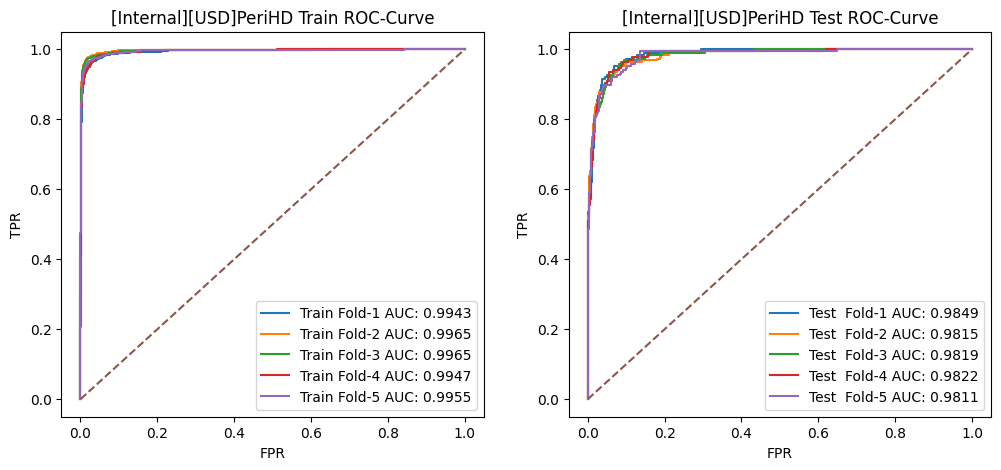

In [8]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, roc_curve, precision_recall_curve, roc_auc_score
from sklearn.metrics import confusion_matrix
import matplotlib.pylab as plt
def get_weight_path(fold, train_type):
    return "./model_weight/PeriHD/weights_periHD_KFold={}[{}-only-merge-sequnece-resplit-pos_neg].h5".format(fold,train_type)
    # return "./demo_weight/weights_periHD_KFold={}[{}]-base.h5".format(fold,train_type)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
history_stack = []
# fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(19,5))
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
CM_train = []
CM_test = []
eval = True
train_type = 'USD'
fold_no = 1
if train_type=="USD":
    in_shape = 512
    training_embedding_ = USD_training_embeddings
    validation_embedding = USD_validation_embeddings
    data_train = USD_data_train
    data_valid = USD_data_valid
train_binary_pred_and_score = []
test_binary_pred_and_score = [ ]
for train, test in kfold.split(training_embedding_, data_train['label'].values.tolist()):
    weight_name = get_weight_path(fold_no, train_type)
    cls_model = create_model(input_shape=(in_shape,))
    if eval==False:
        callbacks = [
            EarlyStopping(     #EarlyStopping is used to stop at the epoch where val_accuracy does not improve significantly
                monitor='val_loss',
                min_delta=1e-4,
                patience=10,
                verbose=0
            ),
            ModelCheckpoint(
                filepath=weight_name,
                monitor='val_loss', 
                mode='min', 
                save_best_only=True,
                save_weights_only=True,
                verbose=0
            )
        ]
        history = cls_model.fit(training_embedding_[train], 
                data_train['label'].values[train], 
                batch_size=64, 
                validation_data=(training_embedding_[test], data_train['label'].values[test]), 
                epochs=300, 
                callbacks=callbacks,verbose=0)
        history_stack.append(history)

    elif eval==True:
        cls_model.load_weights(weight_name)
    train_pred = cls_model.predict(training_embedding_)
    test_pred = cls_model.predict(validation_embedding)
    # binary_pred = np.argmax(pred, axis=1)
    train_binary_pred = (train_pred>0.5).astype(np.int8)
    test_binary_pred = (test_pred>0.5).astype(np.int8)
    train_binary_pred_and_score.append([train_pred, train_binary_pred])
    test_binary_pred_and_score.append([test_pred, test_binary_pred])
    
    tn, fp, fn, tp = confusion_matrix(data_train['label'].values, train_binary_pred).ravel()
    # CM_train.append([tn, fp, fn, tp])
    CM_train.append([data_train['label'].values, train_binary_pred])
    tn, fp, fn, tp = confusion_matrix(data_valid['label'].values, test_binary_pred).ravel()
    # CM_test.append([tn, fp, fn, tp])
    CM_test.append([data_valid['label'].values, test_binary_pred])
    
    fpr, tpr, thresholds = roc_curve(data_train['label'].values, train_pred, pos_label=1)
    auc = roc_auc_score(data_train['label'].values, train_pred)
    axs[0].plot(fpr, tpr, label = "Train Fold-{} AUC: {}".format(fold_no, round(auc, 4)))

    fpr, tpr, thresholds = roc_curve(data_valid['label'].values, test_pred, pos_label=1)
    auc = roc_auc_score(data_valid['label'].values, test_pred)
    axs[1].plot(fpr, tpr, label = "Test  Fold-{} AUC: {}".format(fold_no, round(auc, 4)))
    fold_no=fold_no+1

axs[0].plot([0,1],[0,1], linestyle='--')
axs[1].plot([0,1],[0,1], linestyle='--')

axs[0].legend()
axs[0].set_xlabel("FPR")
axs[0].set_ylabel("TPR")
axs[0].set_title(f"[Internal][{train_type}]PeriHD Train ROC-Curve")
axs[1].legend()
axs[1].set_xlabel("FPR")
axs[1].set_ylabel("TPR")
axs[1].set_title(f"[Internal][{train_type}]PeriHD Test ROC-Curve")

In [9]:
# history_stack[0].history

In [10]:
from sklearn.metrics import precision_score, f1_score, recall_score, accuracy_score
from sklearn.metrics import classification_report
# 已標記資料效能評估
def metric_calc(array_):
    y_test, y_pred = array_
    report = classification_report(y_test, y_pred, output_dict=True)
    # macro_f1 = report['macro avg']['f1-score']
    # weighted_f1 = report['weighted avg']['f1-score']
    # macro_precision = report['macro avg']['precision']
    # weighted_precision = report['weighted avg']['precision']
    # macro_recall = report['macro avg']['recall']
    # weighted_recall = report['weighted avg']['recall']
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro')
    sens = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    spec = tn/(tn+fp)
    return acc, prec, sens, spec, f1

def get_metric(arr):
    mean_arr = np.mean(np.array(arr), axis=0)
    std_arr = np.std(np.array(arr), axis=0)
    return mean_arr, std_arr

In [11]:

# CM_train = np.array(CM_train)
# CM_test = np.array(CM_test)
T_stack, t_stack = [],[]
for T_ in CM_train:
    T_stack.append(metric_calc(T_))
    
for t_ in CM_test:
    t_stack.append(metric_calc(t_))
#內部資料 - Train & Test
mark_train_mean, mark_train_std = get_metric(T_stack)
mark_test_mean, mark_test_std = get_metric(t_stack)
mark_train = pd.DataFrame(['Accuracy','Precision [macro]', 'Sensitivity [macro]', 'Specificity', 'F1-score [macro]'], columns=[f'{train_type} Metric Train'])
for T_, f in zip(T_stack,['fold-1','fold-2','fold-3','fold-4','fold-5']):mark_train[f] = np.round(T_,4)
mark_train['Mean'] = np.round(mark_train_mean,4)
mark_train['Std'] = np.round(mark_train_std,4)

mark_test = pd.DataFrame(['Accuracy','Precision [macro]', 'Sensitivity [macro]', 'Specificity', 'F1-score [macro]'], columns=[f'{train_type} Metric Test'])
for t_, f in zip(t_stack,['fold-1','fold-2','fold-3','fold-4','fold-5']):mark_test[f] = np.round(t_,4)
mark_test['Mean'] = np.round(mark_test_mean,4)
mark_test['Std'] = np.round(mark_test_std,4)

In [12]:
temp = {'Train&Valid斷句': [],'真實答案': [],'預測答案': [],'預測分數': []}
for fold_result in train_binary_pred_and_score:
    train_pred_singel = fold_result[0].flatten()
    train_binary_pred_singel = np.round(fold_result[1].flatten(),3).astype(np.float16)
    for i in zip(USD_data_train['text'].tolist(), USD_data_train['label'].tolist(),train_binary_pred_singel, train_pred_singel):
        if i[1]!=i[2]:
            temp['Train&Valid斷句'].append(i[0])
            temp['真實答案'].append(i[1])
            temp['預測答案'].append(i[2])
            temp['預測分數'].append(i[3])

for fold_result in test_binary_pred_and_score:
    test_pred_singel = fold_result[0].flatten()
    test_binary_pred_singel = np.round(fold_result[1].flatten(),3).astype(np.float16)
    for i in zip(USD_data_train['text'].tolist(), USD_data_train['label'].tolist(),test_binary_pred_singel, test_pred_singel):
        if i[1]!=i[2]:
            temp['Train&Valid斷句'].append(i[0])
            temp['真實答案'].append(i[1])
            temp['預測答案'].append(i[2])
            temp['預測分數'].append(i[3])

failed_pf = pd.DataFrame(temp, columns=['Train&Valid斷句','真實答案','預測答案','預測分數'])

In [13]:
# pd.set_option('display.max_rows', 1000)
# pd.set_option('display.max_columns', 20)
# failed_pf = failed_pf.drop_duplicates(subset='Train&Valid斷句')
# failed_pf.to_csv("./total_fold_faild_predict.csv", index=False, encoding='utf-8-sig')


In [14]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 20)
temp = {'斷句': [],'真實答案': [],'預測答案': [],'預測分數': []}
for i in zip(USD_data_train['text'].tolist(), USD_data_train['label'].tolist(),train_binary_pred.flatten(), train_pred.flatten()):
    if i[1]!=i[2]:
        temp['斷句'].append(i[0])
        temp['真實答案'].append(i[1])
        temp['預測答案'].append(i[2])
        temp['預測分數'].append(np.round(i[3],3))
train_failed_pf = pd.DataFrame(temp, columns=['斷句','真實答案','預測答案','預測分數'])

In [15]:
# train_failed_pf

In [16]:
temp = {'斷句': [],'真實答案': [],'預測答案': [],'預測分數': []}
for i in zip(USD_data_valid['text'].tolist(), USD_data_valid['label'].tolist(),test_binary_pred.flatten(), test_pred.flatten()):
    if i[1]!=i[2]:
        temp['斷句'].append(i[0])
        temp['真實答案'].append(i[1])
        temp['預測答案'].append(i[2])
        temp['預測分數'].append(np.round(i[3],3))
test_failed_pf = pd.DataFrame(temp, columns=['斷句','真實答案','預測答案','預測分數'])

In [17]:
test_failed_pf

,斷句,真實答案,預測答案,預測分數
0,要求HOLD HD， 予回血HOLD HD並ON EKG MONITOR,1,0,0.498
1,徐世平醫師囑ENH HD， 予病房交班,1,0,0.020
2,主訴抽筋至22：10結束透析，今機器面板脫水4.4公斤,1,0,0.326
3,AVF thrill(++)易姿位性低血壓故通知家屬，疑似透析前體重有誤,0,1,0.639
4,至19：30vomitting 予hold HD，告知徐愷翔醫師,1,0,0.221
5,給予Recormon 2000u iv at 1400，透析中無不適,0,1,0.869
6,C/O呼吸不順須坐著透析，at1900訴呼吸喘,1,0,0.246
7,且有vomiting情形，Dr.白囑今脫水4.0Kg即可,1,0,0.046
8,並請徐世平醫師診視， 醫師診視後囑休息20分續透析,1,0,0.194
9,皆無輸血不良反應，透析中血壓穩定無不適,0,1,0.540


In [18]:
pd.concat([train_failed_pf, test_failed_pf]).to_csv("./內部資料Sample預測錯誤結果_Negative和Positive皆做merge.csv", encoding='utf-8-sig', index=False)

In [19]:
mark_train

,USD Metric Train,fold-1,fold-2,fold-3,fold-4,fold-5,Mean,Std
0,Accuracy,0.9886,0.9928,0.9934,0.9904,0.9919,0.9914,0.0017
1,Precision [macro],0.9784,0.9796,0.9833,0.9667,0.9826,0.9781,0.0060
2,Sensitivity [macro],0.9561,0.9793,0.9793,0.9795,0.9708,0.9730,0.0091
3,Specificity,0.9965,0.9960,0.9969,0.9930,0.9970,0.9959,0.0015
4,F1-score [macro],0.9669,0.9794,0.9813,0.9730,0.9766,0.9754,0.0051


In [20]:
mark_test

,USD Metric Test,fold-1,fold-2,fold-3,fold-4,fold-5,Mean,Std
0,Accuracy,0.9524,0.9627,0.9588,0.9607,0.9575,0.9584,0.0035
1,Precision [macro],0.9317,0.9331,0.9228,0.9159,0.9276,0.9262,0.0063
2,Sensitivity [macro],0.8321,0.8842,0.8750,0.8946,0.8628,0.8697,0.0215
3,Specificity,0.9905,0.9876,0.9854,0.9817,0.9876,0.9865,0.0029
4,F1-score [macro],0.8732,0.9066,0.8970,0.9049,0.8916,0.8946,0.0120
